# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from scipy.stats import normaltest, shapiro, norm, t
from scipy import stats

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


##### 1) Is the distribution of body temperatures normal?

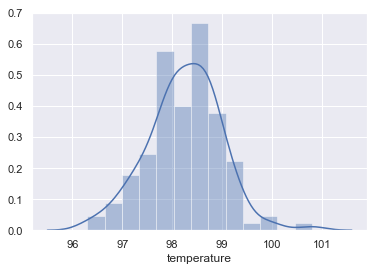

In [24]:
temperature = df['temperature']

# graphical display of the temperature data - histogram
sns.distplot(temperature)
plt.show()

The kernel density estimate looks more or less like a normal distribution.

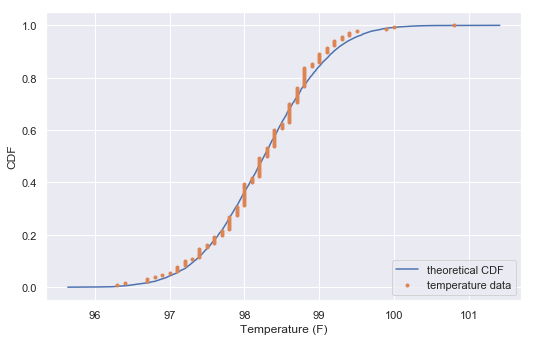

In [4]:
# graphical display of the CDF

# ecdf function
def ecdf(data):
    """ECDF for a **one-dimensional** array of measurements."""
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y

# mean and standard deviation of the data
mean_temp = np.mean(temperature) 
std_temp = np.std(temperature)

# 10,000 samples out of a normal distribution with mean_temp and std_temp
samples = np.random.normal(mean_temp, std_temp, size=10000)

# CDF of the samples and of the temperature data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(temperature)

# Plot
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker='.', linestyle='none')
plt.legend(('theoretical CDF', 'temperature data'), loc='lower right')
plt.xlabel('Temperature (F)')
plt.ylabel('CDF')

plt.subplots_adjust(left=0, bottom=0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

With the CDF it is clearer. Graphically, it looks like a normal distribution.

Since the graphical display could still suggest a slight skewness and kurtosis, we will do two normality tests: D'Agostino's K-squared test and the Shapiro-Wilk test. The null hypothesis, in both cases, assumes normality of the distribution.

In [5]:
# D'Agostino's K-squared test
stat, p_value = normaltest(temperature)
print("D'Agostino's K-squared test: statistic=%.3f; p-value=%.3f" % (stat, p_value))

# Shapiro-Wilk test
stat, p_value = shapiro(temperature)
print("Shapiro-Wilk test: statistic=%.3f; p-value=%.3f" % (stat, p_value))

D'Agostino's K-squared test: statistic=2.704; p-value=0.259
Shapiro-Wilk test: statistic=0.987; p-value=0.233


Since the p-value is greater than a chosen significance level of 5% (and in both cases), we can not reject the 
null hypothesis that the temperature acquired sample came from a normal distributed population.

##### 2) Is the sample size large? Are the observations independent?

In [25]:
# sample size
print(len(temperature))

130


The conditions for assuming the Central Limit Theorem implications are met, since:
 - the sample is more or less symmetric and bigger than 30, the value normally assumed for the validity of the Central Limit Theorem.
 - Probably there was no replacement when retrieving the sample, but the observations are considered to be independent, since they constitute less than 10% of the population size (the 10% rule). 
 - the sample was taken randomly (I assumed that it was).

##### 3) Is the true population mean really 98.6 degrees F?

**First, try a bootstrap hypothesis test.**




- Null hypothesis: "the true population mean is 98.6 degrees Fahrenheit"

- Alternative hypothesis: "the true population mean is different than 98.6 degrees Fahrenheit"

- test statistic: "mean"

In [7]:
# generatebootstrap replicate generation function
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data))) 

# generate several bootstrap replicates function
def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

# population mean
null_hypothesis_mean = 98.6

# mean of the temperature data
mean_temp = np.mean(temperature) 

# shifting the temperature array
mean_shifted = temperature - mean_temp + null_hypothesis_mean

# 10,000 bootstrap replicates from the shifted array
replicates = draw_bs_reps(mean_shifted, np.mean, 10000)

# p-value
p_value = np.sum(replicates <= mean_temp) / len(replicates)

print("p-value:", p_value)
print("significance level = 0.05")

p-value: 0.0
significance level = 0.05


Based on a significance level of 0.05, we have statistical evidence to reject the hypothesis that the true mean is 98.6 degrees Fahrenheit.

**Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?**

- Null hypothesis: "the true population mean is 98.6 degrees Fahrenheit"

- Alternative hypothesis: "the true population mean is different than 98.6 degrees Fahrenheit"

In [8]:
# null hypothesis mean
null_hypothesis_mean = 98.6

# mean and standard deviation of the data
mean_temp = np.mean(temperature)  # 98.249
std_temp = np.std(temperature)  # 0.73

# t statistic
t_statistic = (mean_temp - null_hypothesis_mean) / (std_temp/np.sqrt(len(temperature)))
p_value = stats.t.cdf(t_statistic, df=len(temperature) - 1) * 2

print("t statistic:", t_statistic)
print("p-value:", p_value)

t statistic: -5.475925202078116
p-value: 2.1887464624095175e-07


Considering a significance level of 0.05, we have statistical evidence to say that we reject the null hypothesis, which assumes that the true mean is 98.6 degrees Fahrenheit. I calculated the p-value considering the area of the CDF of the t-distribution that goes until approximately 5.5 standard deviations below or above the mean, since it is symmetric, as the normal distribution.

I used a one-sample test since we want to compare the mean of our sample with a value for which we don't have the data.

**In this situation, is it appropriate to use the  𝑡  or  𝑧  statistic?**

Although the sample is considered to be large (bigger than 30), I chose to use the t statistic since we do not know the standard deviation of the population. The t-distribution converges to the normal distribution. In any case, the results are very close when we use the z statistic because the sample size is large.

**Now try using the other test. How is the result be different? Why?**

In [9]:
# Z-test
z_statistic = (mean_temp - null_hypothesis_mean) / (std_temp/np.sqrt(len(temperature)))
p_value = stats.norm.cdf(z_statistic) * 2

print("z statistic:", z_statistic)
print("p-value:", p_value)

z statistic: -5.475925202078116
p-value: 4.3523151658821886e-08


As noted above, the conclusion is the same since the sample size is big enough and the population very likely follows a normal distribution.

##### 4) Draw a small sample of size 10 from the data and repeat both frequentist tests.

In [10]:
# sample of size 10
sample_10 = np.random.choice(temperature, size=10)

# sample mean and standard deviation
sample_mean = np.mean(sample_10)
sample_std = np.std(sample_10)

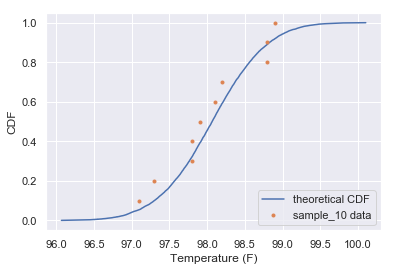

In [11]:
# CDF

# 10,000 samples out of a normal distribution with sample_mean and sample_std
samples = np.random.normal(sample_mean, sample_std, size=10000)

# CDF of the samples and of the temperature data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(sample_10)

# Plot
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker='.', linestyle='none')
plt.legend(('theoretical CDF', 'sample_10 data'), loc='lower right')
plt.xlabel('Temperature (F)')
plt.ylabel('CDF')
plt.show()

In [12]:
# Shapiro-Wilk test
stat, p_value = shapiro(sample_10)
print("Shapiro-Wilk test: statistic=%.3f; p-value=%.3f" % (stat, p_value))

Shapiro-Wilk test: statistic=0.928; p-value=0.431


In [13]:
# t statistic
t_statistic_10 = (sample_mean - null_hypothesis_mean) / (sample_std/np.sqrt(len(sample_10)))
p_value_10 = stats.t.cdf(t_statistic_10, df=len(temperature) - 1)

print("t statistic:", t_statistic_10)
print("p-value:", p_value_10)

t statistic: -2.840690101507187
p-value: 0.0026165688091909145


Since the p-value here is higher than the assumed significance level (5%), we do not have sufficient statistical evidence to reject the null hypothesis.

In [14]:
# Z-test
z_statistic_10 = (sample_mean - null_hypothesis_mean) / (sample_std/np.sqrt(len(sample_10)))
p_value_10 = stats.norm.cdf(z_statistic_10)

print("z statistic:", z_statistic_10)
print("p-value:", p_value_10)

z statistic: -2.840690101507187
p-value: 0.0022508016905792385


With the z statistic the conclusion is the same: we fail to reject the null hypothesis.

**Which one is the correct one to use?**

The correct one to use is the t statistic, since the sample size is inferior to the usual considered value (30), from which the t-distribution starts to approximate the normal distribution. The sample data was taken randomly, with replacement, looks normal and passes tests.

**What do you notice? What does this tell you about the difference in application of the  𝑡  and  𝑧  statistic?**

The p-value is higher when using the t statistic since the t-distribution is similar to the normal distribution but with heavier tails, meaning that it is more prone to accomodate values that are farther away from the mean. This way it is more likely to reject the null hypothesis when using the z statistic, which is likely the correct conclusion in this case. The difference is not very significant, though, regarding the p-value. What is more noticeable is the importance of the size of the sample. As the sample size increases, the probability of making an incorrect conclusion decreases. In this case a sample of 10 seems extremely small to the study we want to make.

##### 5) At what temperature should we consider someone's temperature to be "abnormal"?

**As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach. Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.**

*Frequentist approach*

In [15]:
# margin of error 
margin_error = stats.norm.ppf(0.975) * np.std(temperature)  #one draw

# 95% confidence interval
c_interval_left = np.mean(temperature) - margin_error
c_interval_right = np.mean(temperature) + margin_error

#or 
c_interval = stats.norm.interval(0.95, loc=mean_temp, scale=std_temp)

print("For one draw, the 95% confidence interval is [", c_interval_left, ",", c_interval_right, "]")

For one draw, the 95% confidence interval is [ 96.81775582674824 , 99.68070571171332 ]


From the frequentist approach, a temperature outside the computed values could be considered to be abnormal.

*Bootstrap approach*

In [16]:
# bootstrap replicates of the mean 
bs_replicates = draw_bs_reps(temperature, np.mean, 10000)

# 95% confidence interval
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

print('95% confidence interval =', conf_int)

95% confidence interval = [98.12307692 98.37461538]


A temperature outside the boundaries of the computed value would be considered abnormal, according to the method I used for the bootstrap approach. I considered, however, 10000 replicas of the mean of the data, so the interval is tighter.

##### 6) Is there a significant difference between males and females in normal temperature?


First I will look graphically how the temperature of the two gender behave

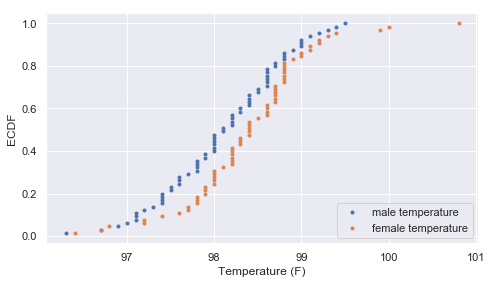

In [17]:
# selection of both gender temperature values
male_temp = df[df['gender'] == 'M'].temperature
female_temp = df[df['gender'] == 'F'].temperature

# ECDF of both
x_male, y_male = ecdf(male_temp)
x_female, y_female = ecdf(female_temp)

# Plot 
plt.plot(x_male, y_male, marker='.', linestyle='none')
plt.plot(x_female, y_female, marker='.', linestyle='none')

plt.legend(('male temperature', 'female temperature'), loc='lower right')
plt.xlabel('Temperature (F)')
plt.ylabel('ECDF')
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.8, wspace=0.6, hspace=0.4)
plt.show()

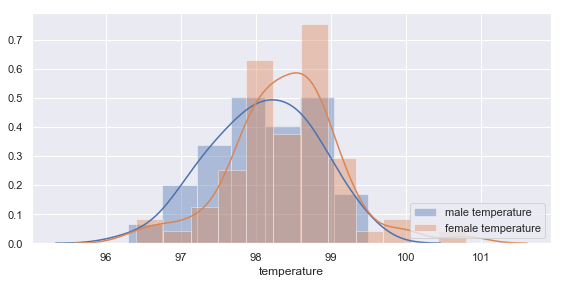

In [18]:
# PDF
sns.distplot(male_temp)
sns.distplot(female_temp)
plt.legend(('male temperature', 'female temperature'), loc='lower right')
plt.subplots_adjust(left=0, bottom=0, right=1.2, top=0.8, wspace=0.6, hspace=0.4)
plt.show()

Graphically, it appears to be a clear difference between the two genders in normal temperature. Females seem to have higher values on average and the variance appear larger as well. Both appear to follow a normal distribution, although the male one seems closer.

In [19]:
print("sample size for male temperature:", len(male_temp))
print("sample size for female temperature:", len(female_temp))

sample size for male temperature: 65
sample size for female temperature: 65


Again, the conditions that were mentioned above for the validity of the use of test hypothesis are met, since the only extra criteria to check in this case was the length of the samples of each gender.

Considering, then, a hypothesis test, I assume that what it is asked is if there is a significant difference between their temperature mean, but I will check for a significant difference between their temperature distribution, as well as in their temperature mean, a less restrictive test.

First I will study if they have the same distribution and compute the probability of them having a difference in mean temperature as extreme as they have in the sample (either larger or smaller, so I will use the absolute value when computing the replicas):
   - Null hypotesis: "there is not a significant difference between males and females in their normal temperature distribution"
   - test statistic: "difference between the means"

In [20]:
# empirical difference between means
emp_diff_means = np.mean(female_temp) - np.mean(male_temp)

print("The observed difference between the means (of female less male) is", emp_diff_means)

The observed difference between the means (of female less male) is 0.289230769230727


*Bootstrap approach*

In [21]:
# function for generating a permutation replicate
def permutation_sample(data1, data2):
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

# Generating permutation replicates
def draw_perm_reps(data_1, data_2, func, size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

# diference of means:
def diff_of_means(data_1, data_2):
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

# 10,000 permutation replicates
perm_replicates = draw_perm_reps(female_temp, male_temp, diff_of_means, size=100000)

# p-value
p_value = np.sum(abs(perm_replicates) >= emp_diff_means) / len(perm_replicates)

print('p-value =', p_value)

p-value = 0.0242


Considering a significance level of 5%, we have statistical evidence to reject the null hypothesis.

Testing now if they have the same mean, doing a two-sample bootstrap hypothesis test:

  - Null hypotesis: "there is not a significant difference between males and females in their normal temperature mean"
  - test statistic: "difference between the means"

In [22]:
# shifted arrays
male_temp_shifted = male_temp - np.mean(male_temp) + np.mean(temperature)   
female_temp_shifted = female_temp - np.mean(female_temp) + np.mean(temperature)  

# 10,000 bootstrap replicates from shifted arrays
bs_replicates_male = draw_bs_reps(male_temp_shifted, np.mean, 100000)
bs_replicates_female = draw_bs_reps(female_temp_shifted, np.mean, 100000)

# replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_female - bs_replicates_male

# p-value
p_value = sum(abs(bs_replicates) >= emp_diff_means) / len(bs_replicates) 

print('p-value =', p_value)

p-value = 0.02171


Considering a significance level of 5%, we have statistical evidence to reject the null hypothesis.

Testing now via the frequentist approach:

*Frequentist approach*

   - Null hypotesis: "there is not a significant difference between males and females in normal temperature mean"
   - test statistic: "difference between the means"

In [23]:
# empirical difference between means
emp_diff_means = np.mean(female_temp) - np.mean(male_temp)

# standard deviation of the new distribution
new_std = np.sqrt((np.var(male_temp)/len(male_temp))+(np.var(female_temp)/len(female_temp)))

limit = stats.norm.ppf(0.975) * new_std

print("The observed difference between the means is:", emp_diff_means)
print("The standard deviation of the new distribution is:", new_std)
print("So the limit for not rejecting the null hypothesis is", limit)

# p-value
p_value = (1 - stats.norm.cdf(emp_diff_means, scale=new_std)) * 2
print("The probability of having a result as extreme as the observed is", p_value)

The observed difference between the means is: 0.289230769230727
The standard deviation of the new distribution is: 0.12557668521231213
So the limit for not rejecting the null hypothesis is 0.24612578031405538
The probability of having a result as extreme as the observed is 0.021266451830129318


Hence, we reject the null hypothesis.

**What testing approach did you use and why?**


I used both approaches.

**Write a story with your conclusion in the context of the original problem.**

The mean normal body temperature was held to be 98.6 degrees Fahrenheit for more than 120 years since it was first conceptualized. We started by verifying if the distribution of the temperature followed a normal distribution, based on our sample. That was indeed the case, after performing exploratory data analysis and two hypothesis tests.

We then proceed to verify if the stated normal body temperature was in fact 98.6 degrees Fahrenheit. In order to do that, we first verified the necessary conditions to apply our subsequent procedures. Then, with both bootstrap and frequentist approaches, we gathered sufficient statistical evidence to reject the hypothesis that the true temperature was not the assumed one. Our sample and our result was sufficient enough to state that with high confidence.

We then tested the hypothesis of a significant difference between male and female temperature. We concluded that there is, both in their mean and distribution. We can not, however, state that with as much confidence as before. The p-value in all cases was between 2.1 and 2.4%, so the conclusion may also depend on what experts of the matter think.